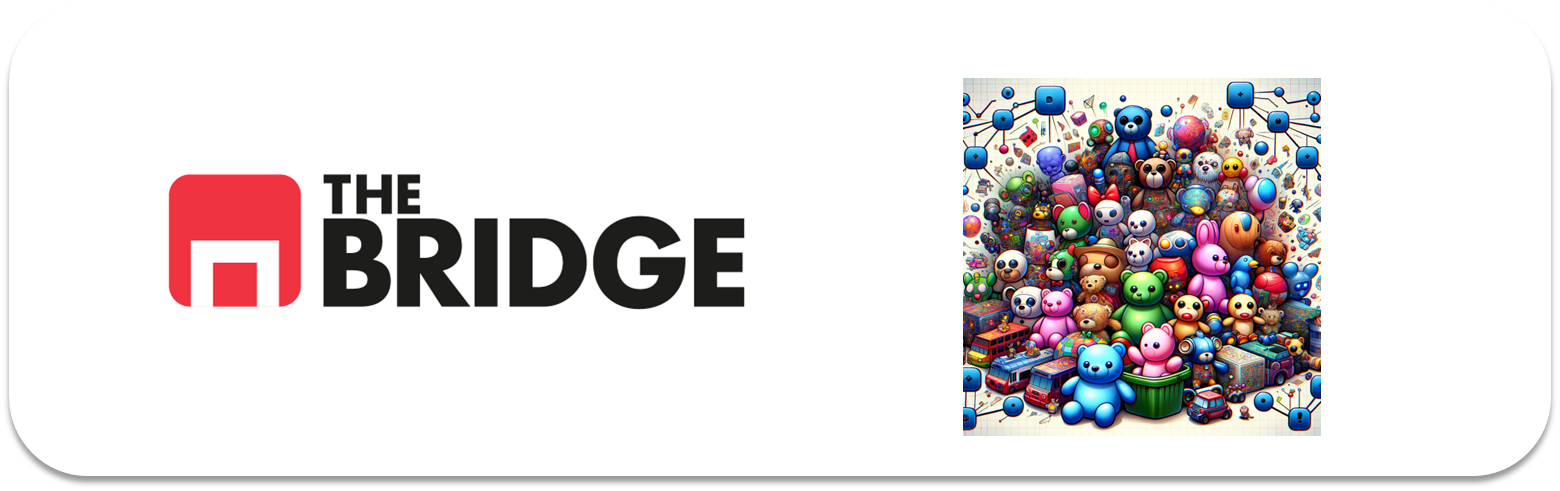

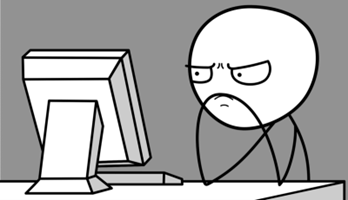

Para ejercitarte y afianzar lo aprendido sobre **DBSCAN**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Problema y "justificación": DBSCAN

Como sabemos, existen diversas técnicas de clusterización comprendidas por algoritmos de machine learning no supervisados, cuya finalidad es agrupar distintos elementos de una data sin la necesidad de estar previamente etiquetados. 

Anteriormente utilizamos el algoritmo de KMeans, sin embargo, dicho algoritmo tiene algunas limitaciones, como el hecho de que no siempre es sencillo obtener un número de K clusters óptimo o que algunas distribuciones de datos no se ajustan a la agrupación por clusters debido a la naturaleza del algoritmo. Para estos casos existen diversos algoritmos de clusterización. 

A continuación, vamos a utilizar el algoritmo DBSCAN (Density-Based Spatial Clustering of Applications with Noise) para capturar grupos en data con patrones relativamente complejos.

Utilizaremos data de clientes de un distribuidor al por mayor, en el que se recogen por línea ventas a diferentes establecimientos y empresas de sus productos (aunque no se incluye el identificador de establecimiento) y cuyo objetivo es obtener agrupacioines interesantes (agrupaciones no predefinidas de productos que se suelen comprar juntos):

Features:

    1) FRESH: Gastos en productos frescos;
    2) MILK: Gastos en productos lacteos;
    3) GROCERY: Gastos en comestibles;
    4) FROZEN: Gastos en congelados;
    5) DETERGENTS_PAPER: Gastos en detergentes y derivados del papel;
    6) DELICATESSEN: Gatos en comestibles finos;
    7) CHANNEL: Canal que utilizan los clientes para vender - Horeca (Hotel/Restaurant/Cafeterías) o Retail channel (Al por menor);
    8) REGION: Región del cliente;

Fuente: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import bootcampviztools as bt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


### Ejercicio 1

Carga los datos y haz una primera exploración, incluyendo una descripción de las variables numéricas.

In [2]:
df_wholesome_customers = pd.read_csv('data/wholesale-customers-data.csv')

In [3]:
df_wholesome_customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df_wholesome_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [5]:
df_wholesome_customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


*Los datos están bastante limpios y no tenemos valores nulos, sin embargo al observar los máximos de varias columnas como Fresh, Grocery y otras, detectamos valores muy por encima de la media o percentiles. Hagamos un análisis un poco más detallado...*

$$***$$

Es hora de hacer un miniEda (cuyo objetivo en el caso de clusterizacion no es obtener features para predicción de un target que no tenemos), cuyo objetivo es poder intuir posibles agrupaciones y su número, detectar si hay que hacer transformaciones y escalado en las variables y cuál

### Ejercicio 2



Pinta el histograma de las variables y determina cuáles podríamos considerar numéricas continuas y cuáles numéricas discretas (o categóricas)

array([[<Axes: title={'center': 'Channel'}>,
        <Axes: title={'center': 'Region'}>,
        <Axes: title={'center': 'Fresh'}>],
       [<Axes: title={'center': 'Milk'}>,
        <Axes: title={'center': 'Grocery'}>,
        <Axes: title={'center': 'Frozen'}>],
       [<Axes: title={'center': 'Detergents_Paper'}>,
        <Axes: title={'center': 'Delicassen'}>, <Axes: >]], dtype=object)

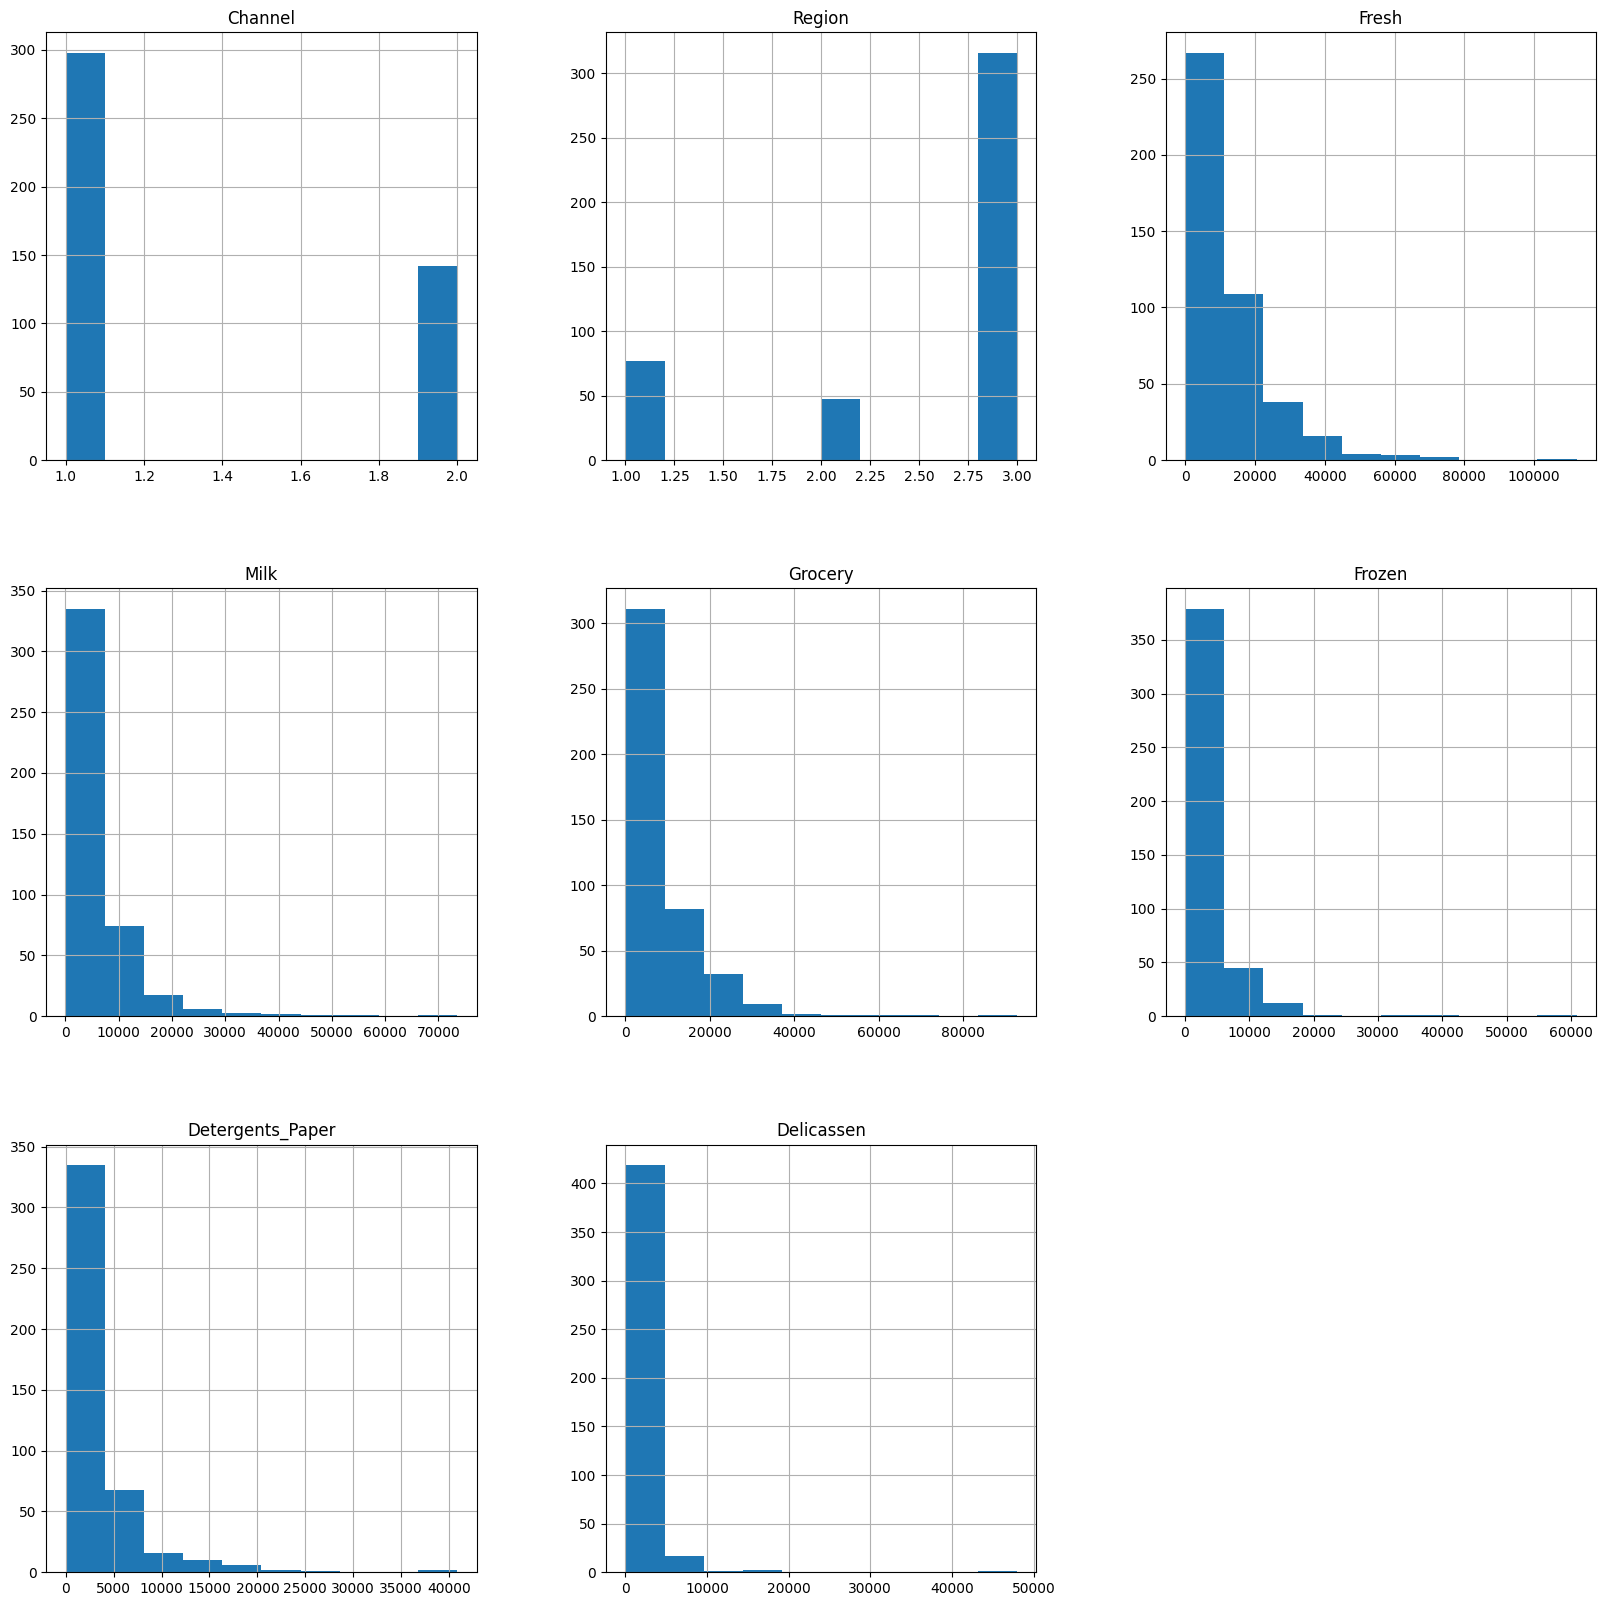

In [6]:
df_wholesome_customers.hist(figsize=(20,20))

In [7]:
features_cat = ["Channel","Region"]
features_num = [col for col in df_wholesome_customers if col not in features_cat]

*Como era de esperar, teniendo en cuenta las definiciones de cada variable o columna, "Channel" y "Region" son asimilables a categóricas y el resto son numéricas continuas.*  
*Así de primeras podríamos considerar que hay que aplicar transformaciones a todas las variables pero merece la pena analizar un poco más... vamos al siguiente ejercicio (NOTA: Es probable que no veas por qué merece la pena analizar más antes de transformar, pero eso tiene que ver con el conocimiento de dominio, ya que las ventas están agrupadas para los dos canales y no es lo mismo vender al sector hostelero que a los supermercados y tiendas de alimentos*).

### Ejercicio 3

Antes de decidir sobre las agrupaciones, vamos pintar los histrogramas pero separando por canal (ya que es un elemento muy diferenciador del tipo de venta que se realiza a mayorista). Muestra gráficamente para cada variable numérica su histograma para cada canal (Horeca y Retail). 

*Empleando un método directo y no con funciones, como podríamos haber hecho con las bootviztools, para que tengas otras versiones...*

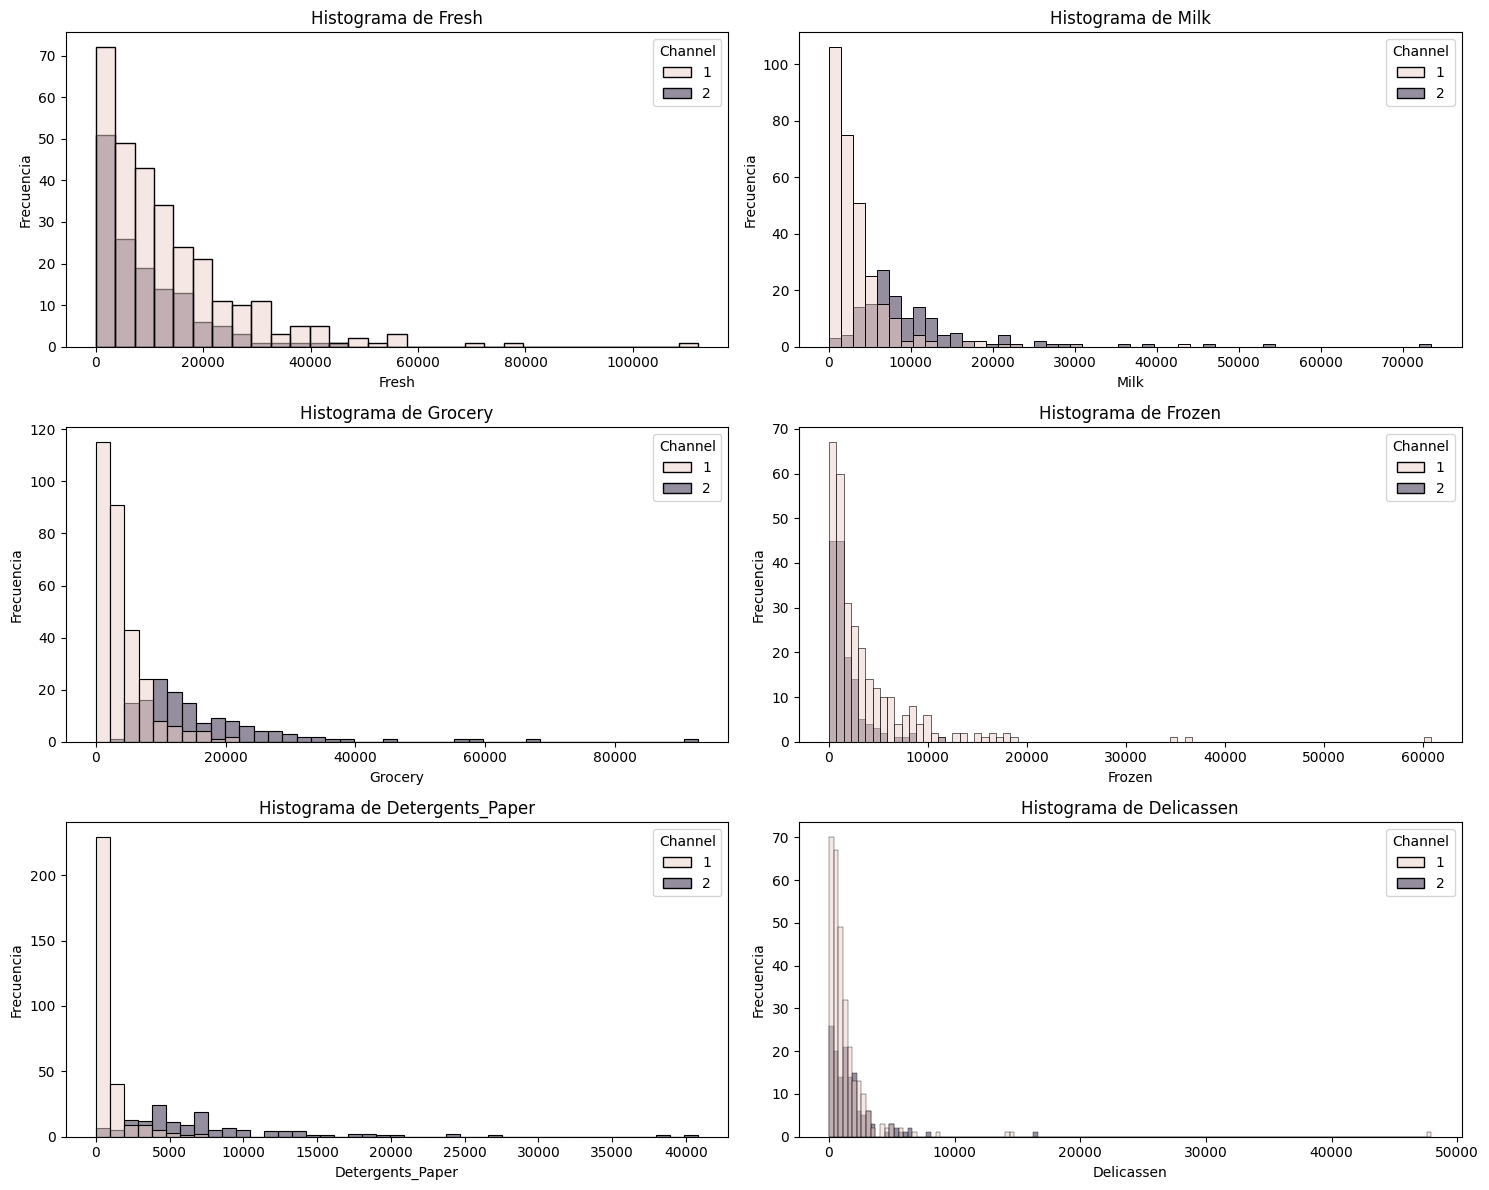

In [8]:
columns = df_wholesome_customers.columns[2::]  # Columnas numéricas
n_cols = len(columns) # Número de columnas para pintar

# Calcular cuántas filas necesitaremos, asumiendo 2 columnas (subplots) por fila
n_rows = n_cols // 2 if n_cols % 2 == 0 else (n_cols // 2) + 1

# Configurar el tamaño de la figura para acomodar todos los subplots
plt.figure(figsize=(15, n_rows * 4))  # Ajusta el tamaño según el número de filas, altura por fila

for i, column in enumerate(columns):
    plt.subplot(n_rows, 2, i + 1)  # Crea subplots en una cuadrícula de n_rows x 2
    sns.histplot(data=df_wholesome_customers, x=column, hue='Channel')
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')

plt.tight_layout()  # Ajusta automáticamente los subplots para que encajen en la figura
plt.show()

*Si nos quedamos únicamente con el histograma del ejercicio anterior aplicaríamos transformación a todas las columnas. Mirándo aquí los valores, no sólo se ve que hay numéricas (como "Milk" y "Grocery" o "Detergents_Paper") que aunque con cierta cola no están tan concentradas en la izquierda y luego tienen una larga cola.*  

*Otro elemento que podemos ver es que son distribuciones diferentes en varios productos, lo que invita a hacer una agrupación o clustering difertente por "Channel"*

### Ejercicio 4

Analicemos los outliers. Obten los outliers a partir de los diagramas de boxplot para todos los datos y luego separados por canal.

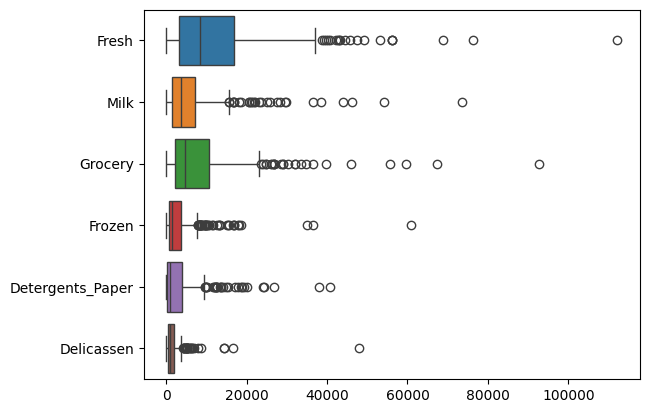

In [9]:
# Visualizando outliers con boxplot
sns.boxplot(df_wholesome_customers[features_num], orient='h');

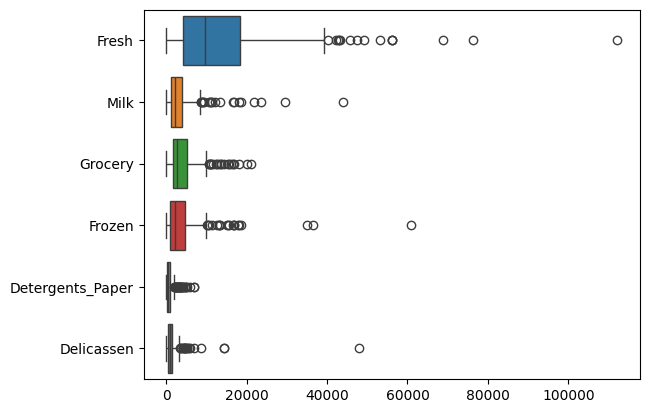

In [10]:
# Para HORECA
sns.boxplot(df_wholesome_customers[df_wholesome_customers.Channel == 1][features_num], orient='h');

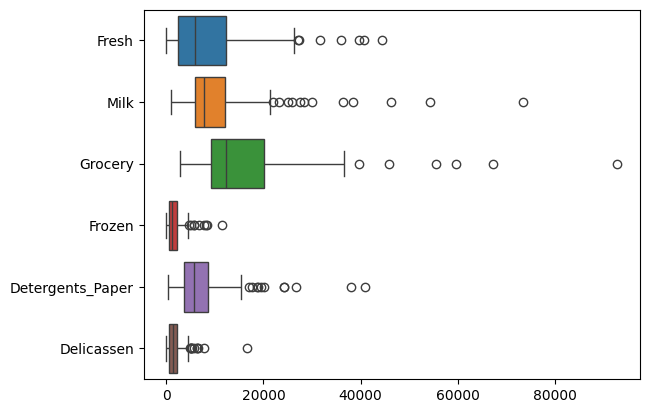

In [11]:
# Para Retail
sns.boxplot(df_wholesome_customers[df_wholesome_customers.Channel == 2][features_num], orient='h');

*Hay outliers significativos en todas ellas y para los dos canales (que también podíamos observar en los histogramas), por lo que cualquier clustering basado en distancias (o sea todos los que hemos vistos) van a necesitar que escalemos, pero antes...*

### Ejercicio 5

Vamos a intentar detectar posibles agrupaciones en los datos con variables dos a dos. Utiliza un pairplot de sns para mostrar los scatter plots de las variables numéricas dos a dos e intentar visualizar algún clustering e incluso justificar usar kMeans o DBSCAN. En este ejercicio hazlo para todo el dataset.

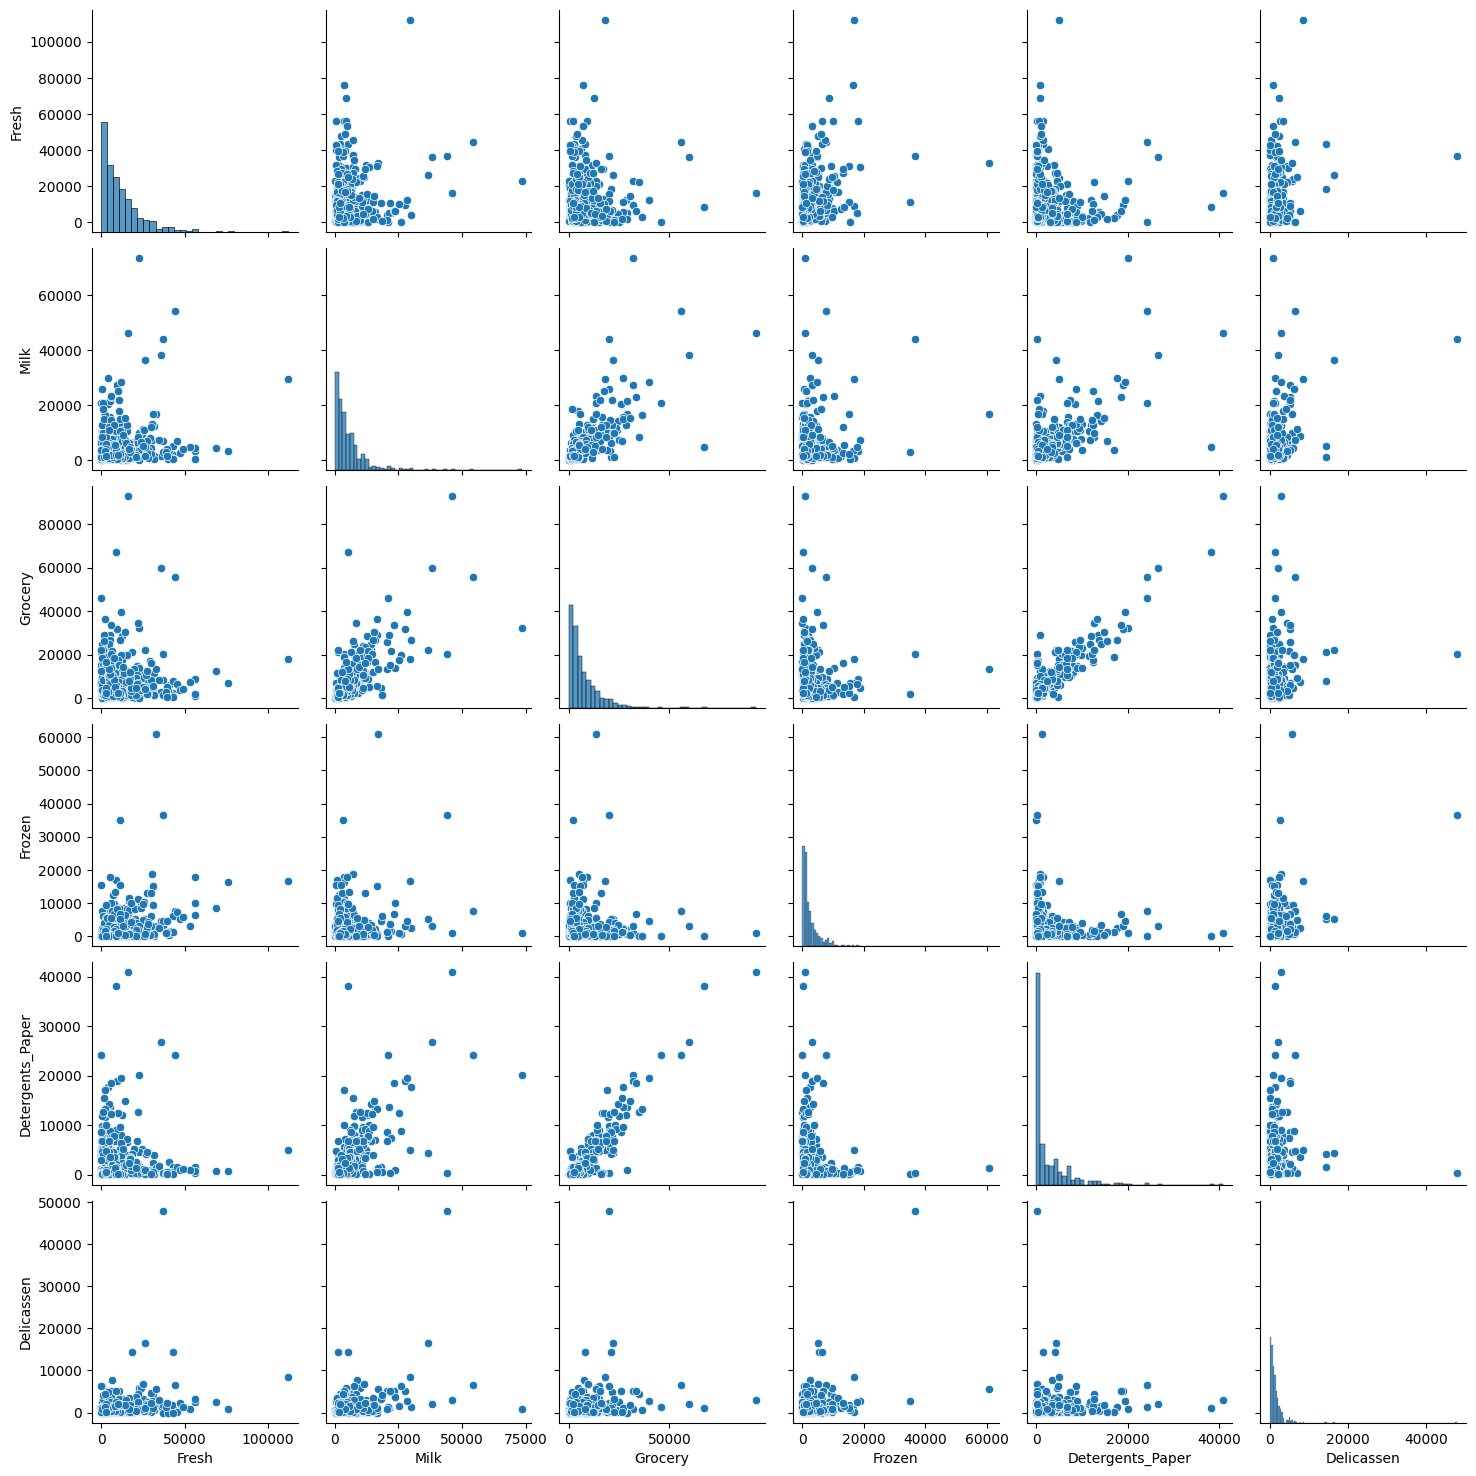

In [12]:
sns.pairplot(df_wholesome_customers[features_num])

*Así tal cual no se ven agrupaciones claras (no hay "manchurrones" separados, son trazos) para un k-means, de hecho tampoco se ven zonas separadas en densidad (zonas de puntos, aunque irregulares, separadas por zonas blancas, aunque el tamaño del gráfico influye). Así tal cual no pinta bien para ningún algoritmo*

### Ejercicio 6

Repite el ejercicio 5 pero separando por canal. Emplea el argumento hue del pairplot para no tener que hacer dos pairplots diferentes. 

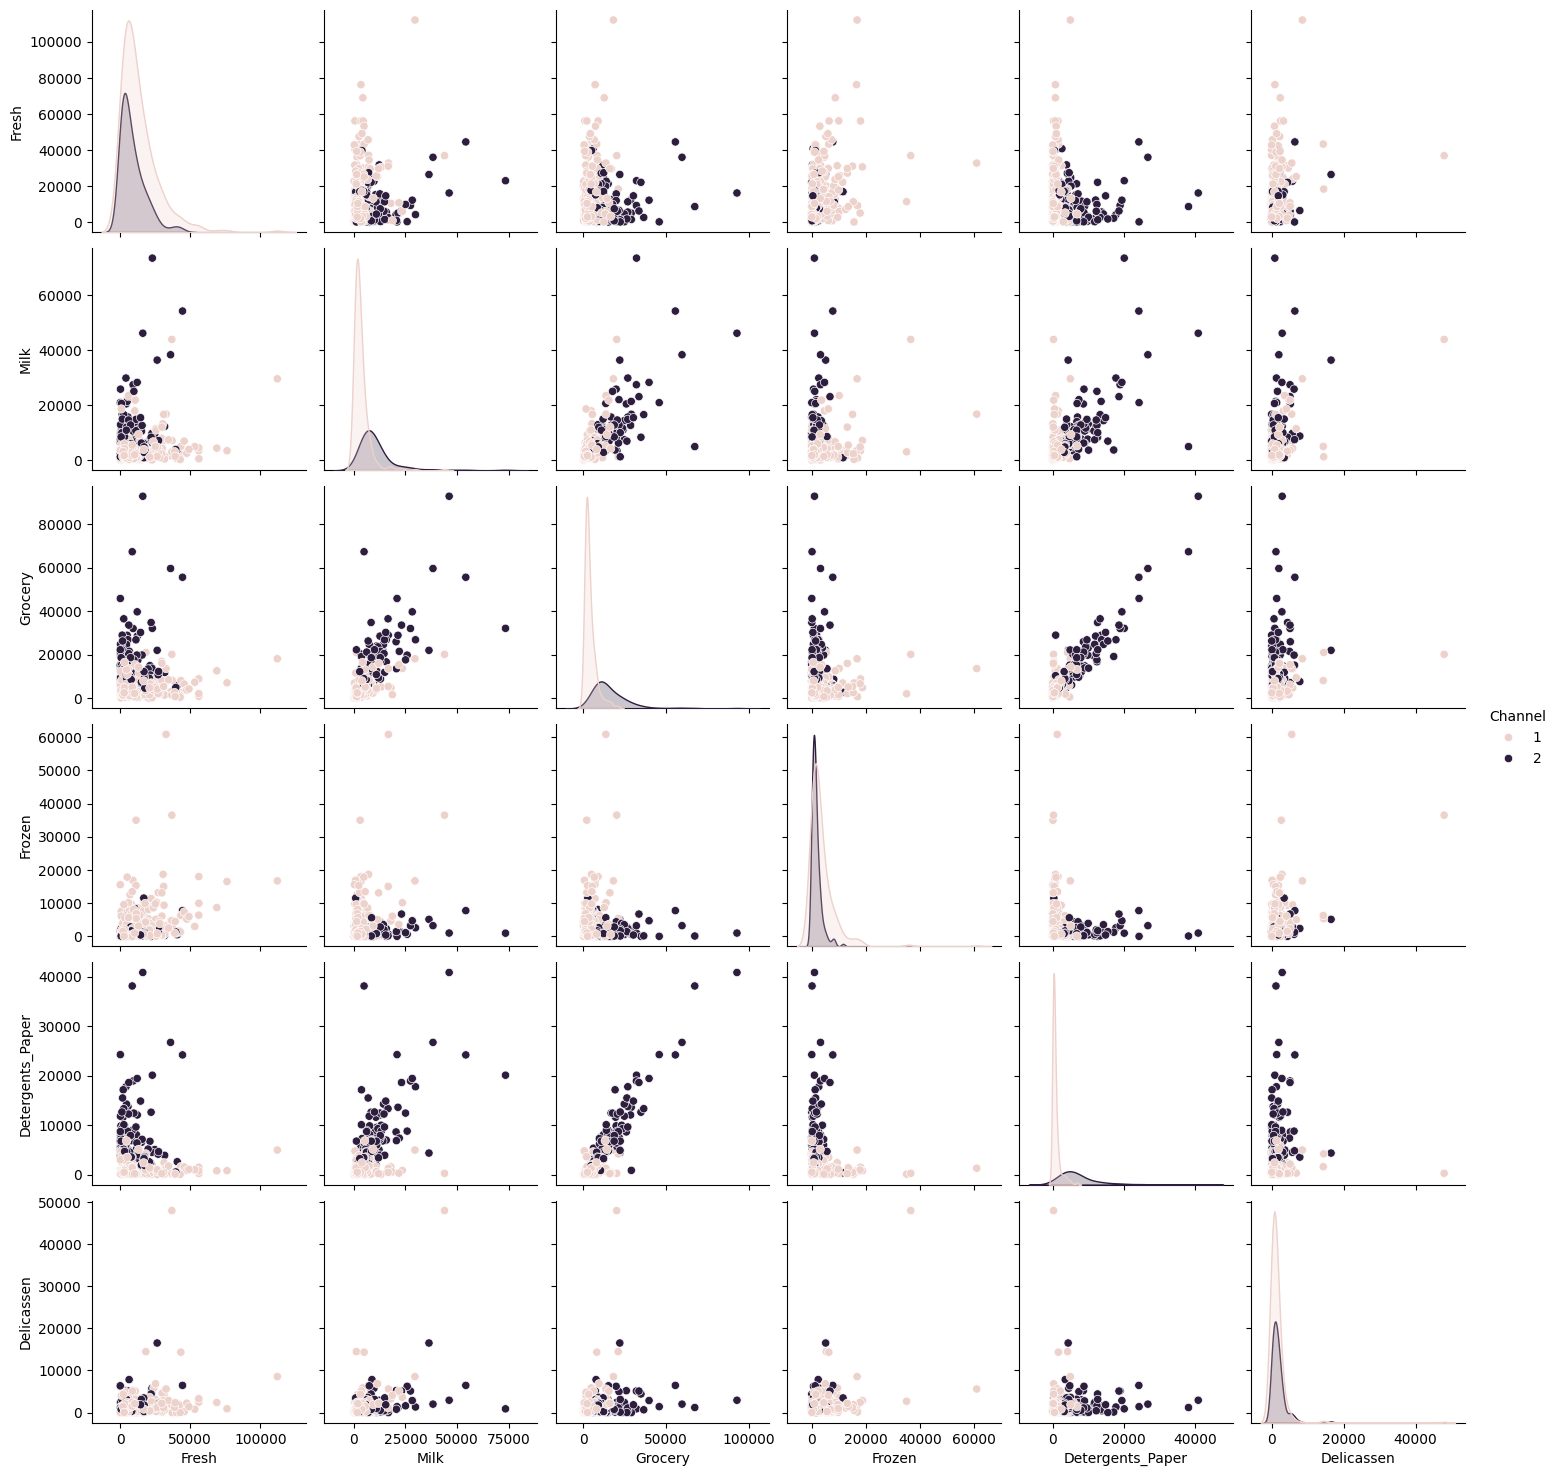

In [13]:
sns.pairplot(df_wholesome_customers[features_num + ["Channel"]], hue = "Channel")

*Como se podía intuir, pero sólo eso, sí que parece haber dos regiones de puntos según el canal (fijate en por ejemplo en Fresh y Grocery (columna 1, fila 3 empezando por arriba); hay dos regiones una inferior para canal 1 (HORECA) y otra superior para canal 2 (Retail). Pero también puedes ver que están demasiado juntas como para que un kmeans las consiga separar tal cual. En estos casos, tiene mejor pinta usar un DBSCAN* 

*En otras palabras, al contrastar los scatter plots podemos empezar a intuir que un clustering con KMeans podría no ser lo más conveniente por la distribucion de los datos, no se observan los típicos focos de agrupación y patrones (circulos o "blobs") que solemos buscar agrupar con KMeans, siendo un patrón mas irregular. Otro factor para considerar es la presencia de multiples outliers, el DBSCAN suele ser robusto ante outliers y ruido ya que no obliga a los mismos a ser parte de un cluster.*

### Ejercicio 7

Si has logrado hacer los dos ejercicios anteriores (y si no consulta su solución) tendrás una idea un poco más clara de por qué es interesante la clusterización con DBSCAN mejor que con KMeans. Así que vamos a utilizarlo, pero antes escalemos los datos, transformándolos primero (de primeras no vamos a distinguir entre canales, hazlo con todo el dataseet). Es decir aplica la tranformación que creas necesaria en las columnas numéricas que creas conveniente. Hazlo en un dataframe copiado del original para poder interpretar los valores correctamente al final.

In [14]:
df_wholesome_customers_scal = df_wholesome_customers.copy()

array([[<Axes: title={'center': 'Fresh'}>,
        <Axes: title={'center': 'Milk'}>],
       [<Axes: title={'center': 'Grocery'}>,
        <Axes: title={'center': 'Frozen'}>],
       [<Axes: title={'center': 'Detergents_Paper'}>,
        <Axes: title={'center': 'Delicassen'}>]], dtype=object)

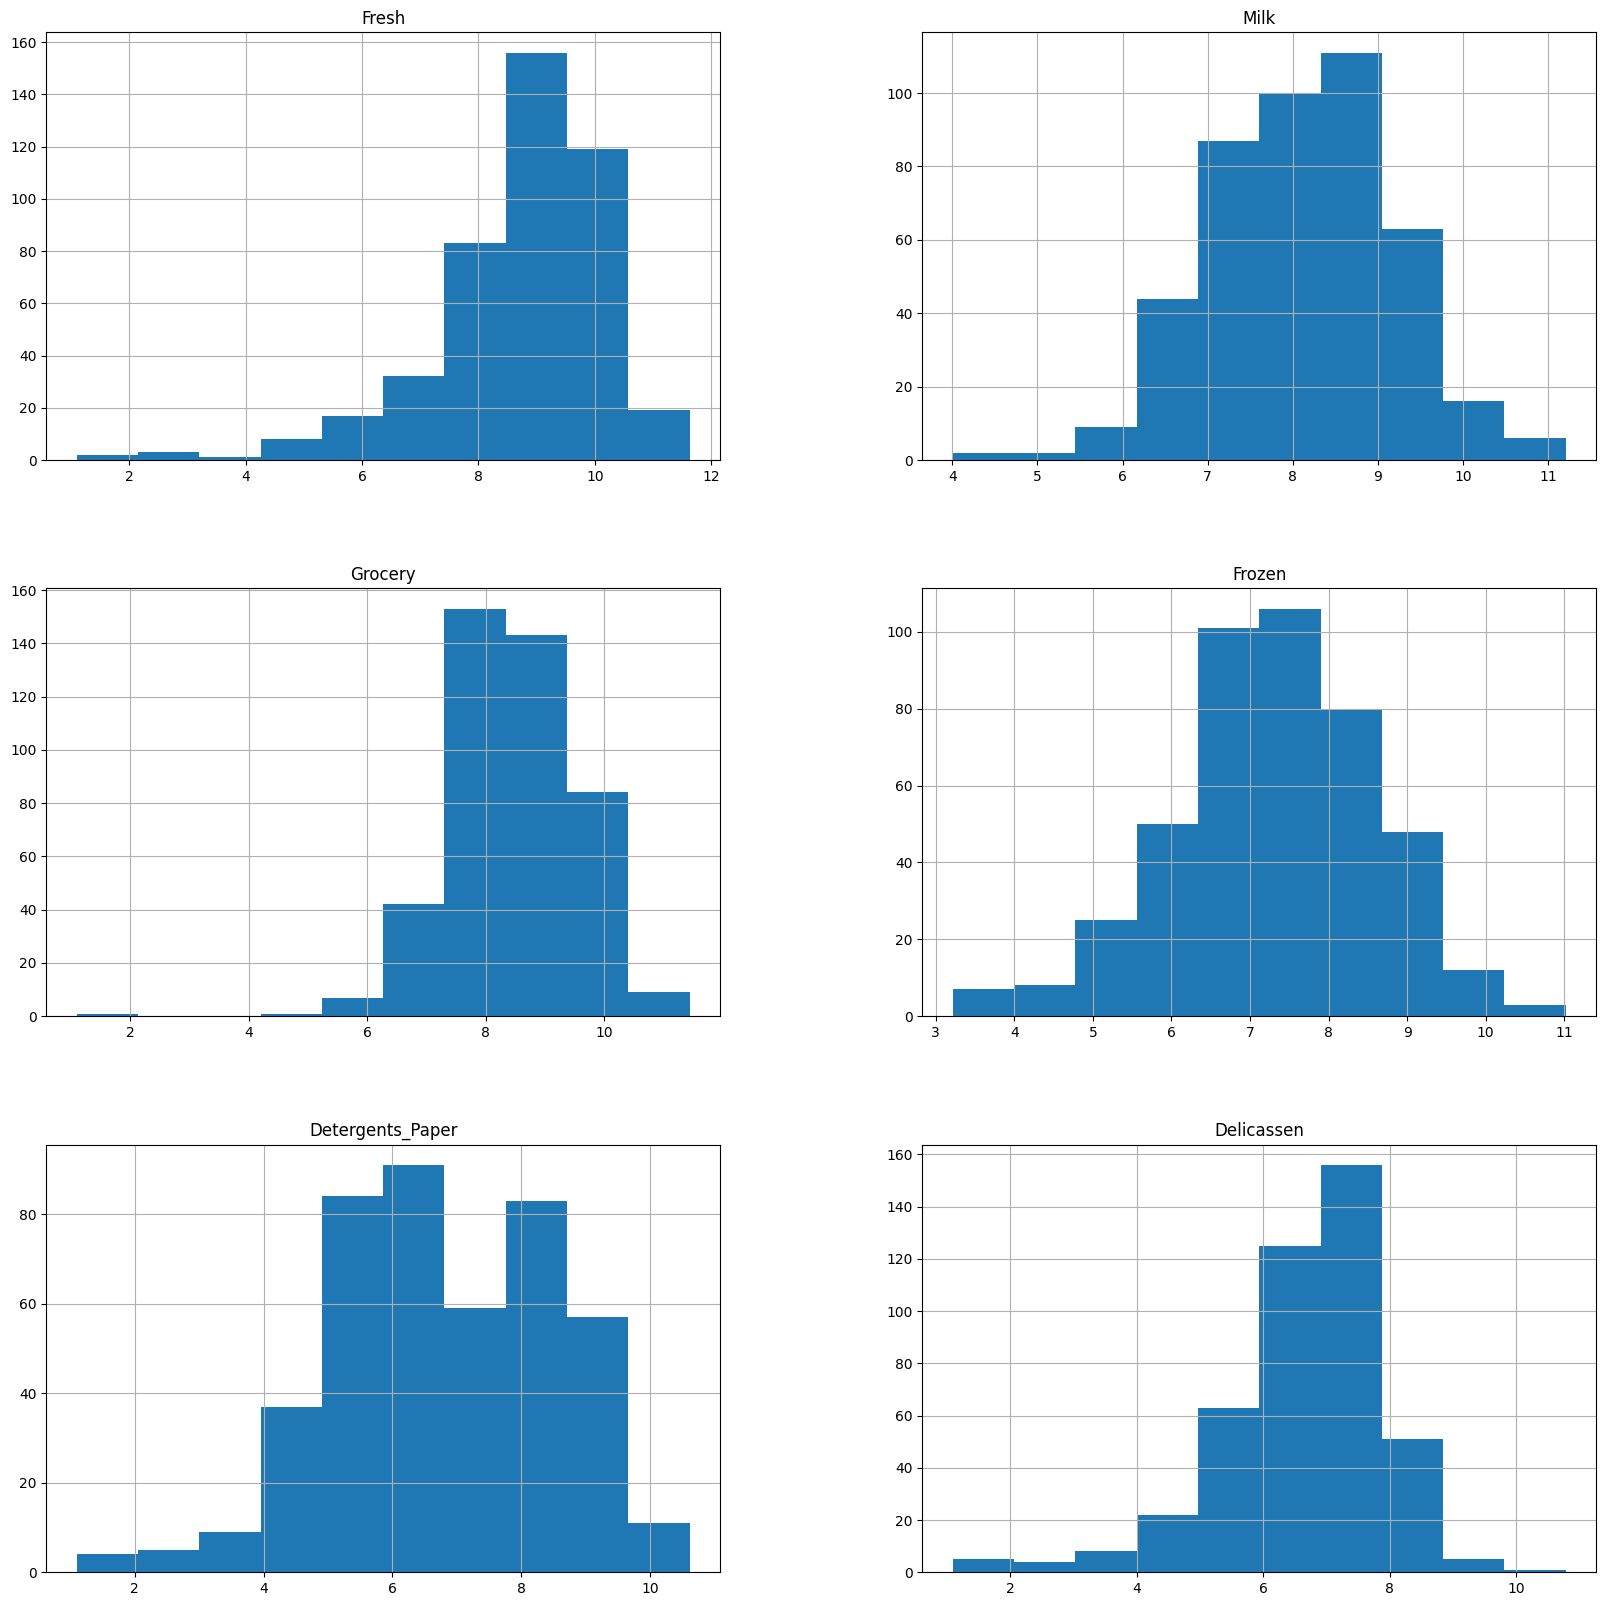

In [15]:
df_wholesome_customers_scal[features_num] = df_wholesome_customers_scal[features_num].apply(np.log) # Según el describe del ejercicio 1 todos los valores mínimos están por encima de 0
df_wholesome_customers_scal[features_num].hist(figsize=(20,20))
    
    

### Ejercicio 8

Escala las columnas que creas necesario. Si no lo tienes claro, escala todas.

In [16]:
scaler = StandardScaler()
df_wholesome_customers_scal = scaler.fit_transform(df_wholesome_customers_scal)

### Ejercicio 9

En el caso de los modelos no supervisados, una vez hemos tratado las features hay que escoger los hiperparámetros. En el caso de dBSCAN no es el número de clústeres, sino la distancia `eps` que determina el vecindario de un punto y el número de vecinos a partir del cual se decide si una instancia es core o no (`min_samples`). 

Una forma de hacerlo es iterar sobre rangos de estos dos hiperparámetros midiendo el porcentaje de "anomalías" que detecta y considerando como punto de parada un valor por debajo del 10%.

NOTA: Usa el doble de cantidad de tus features para el mínimo de elementos y un rango para el epsilon de 0.001 a 3. Para min_samples vamos a usar un valor "estimado" que corresponde a 2 veces el número de features empleadas.

In [17]:
outlier_percent = []

for eps in np.linspace(0.001,3,50): # Genera 50 valores equidistantes entre 0.001 y 3
    
    # Creamos el modelo
    dbscan = DBSCAN(eps=eps,min_samples=2*df_wholesome_customers_scal.shape[1]) # min_samples dos veces el ´numero de features -> 2 por dimensión del hiperespacio en el que representamos el conjunto de puntos... No le des muchas vueltas es un número muy orientativo. Pero piensa que si fuera un recta querrías 2 valores, un plano 4, un cubo 6...
    dbscan.fit(df_wholesome_customers_scal)
   
     
    # Registramos el porcentaje de anomalías (recuerda que se etiquetan como -1)
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    outlier_percent.append(perc_outliers)

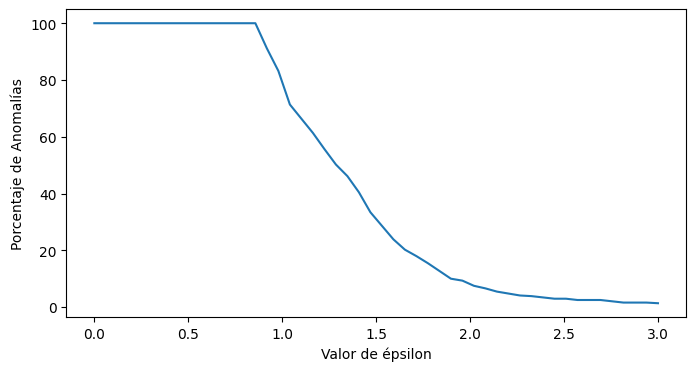

In [18]:
#Vamos a pintar ahora el porcentaje de anomalías vs el valor de eps probado
plt.figure(figsize = (8,4), dpi = 100)
sns.lineplot(x=np.linspace(0.001,3,50),y=outlier_percent)
plt.ylabel("Porcentaje de Anomalías")
plt.xlabel("Valor de épsilon")
plt.show()

*Aplicamos una estimación tipo "codo" para valores por debajo del 10%, veamos para eps entre 1.5 (por ver bien el decrecimiento del porcentaje de anomalías) y 2.2 (este a ojo)*

In [19]:
for indice,eps in [(indice,val) for indice,val in enumerate(np.linspace(0.001,3,50)) if 1.5 <= val <= 2.2]:
    print(f"Para {eps}: {outlier_percent[indice]}% de anomalías")

Para 1.5311020408163265: 28.636363636363637% de anomalías
Para 1.5923061224489796: 23.863636363636363% de anomalías
Para 1.6535102040816325: 20.227272727272727% de anomalías
Para 1.7147142857142856: 17.954545454545453% de anomalías
Para 1.7759183673469388: 15.454545454545455% de anomalías
Para 1.8371224489795916: 12.727272727272727% de anomalías
Para 1.8983265306122448: 10.0% de anomalías
Para 1.9595306122448979: 9.318181818181818% de anomalías
Para 2.020734693877551: 7.5% de anomalías
Para 2.081938775510204: 6.590909090909091% de anomalías
Para 2.1431428571428572: 5.454545454545454% de anomalías


*A partir de 1.89 la pendiente de decrecimiento (velocidad de decrecimiento) se va ralentizando bastante, cualquier valor a partir de ahí  es interesnate. Por coger uno redondo nos quedamos con 2*

### Ejercicio 10

Entrena un clustering DBSCAN con el valor que hayas encontrado como mejor en el ejercicio anterior (si no has visto claramente un valor, usa eps = 2) y `min_samples` a dos veces el número de features empleadas.

In [20]:
#fit DBSCAN with eps = 2
#dbscan = DBSCAN(eps=2, min_samples= 2*len(df_wholesome_customers.columns.to_list()))
dbscan = DBSCAN(eps = 2)
dbscan.fit(df_wholesome_customers_scal)

DBSCAN(eps=2)

In [21]:
dbscan.min_samples

5

### Ejercicio 11

Agrega las etiquetas generadas con DBSCAN a tu dataframe original e interpreta los resultados (observa el número de etiquetas, recuerda que -1 no es un cluster son anomalías o outliers) luego contesta a: ¿Qué grupos o patrones fue capaz de capturar el DBSCAN? (Haz las tablas de contingencia de las etiquetas con las dos variables categóricas, por separado, por ejemplo y a partir de ahí justifica tu respuesta)

*Analizamos las etiquetas*

In [22]:
df_wholesome_customers['Labels'] = dbscan.labels_
df_wholesome_customers['Labels'].value_counts()

Labels
 1    279
 0    135
-1     26
Name: count, dtype: int64

*Lo primero, ha encontrado 2 clusters o agrupaciones... Ya podemos suponer a qué corresponden por lo visto anteriormente... verdad...*

*Si hacemos un conteo de valores de cada etiqueta por canal (Channel) nos damos cuenta que el DBSCAN realizó una agrupación por canales*

In [23]:
# Para Region

pd.crosstab(df_wholesome_customers["Labels"], df_wholesome_customers["Region"])

Region,1,2,3
Labels,,,
-1,5,4,17
0,17,17,101
1,55,26,198


In [24]:
# Para Channel

pd.crosstab(df_wholesome_customers["Labels"], df_wholesome_customers["Channel"])

Channel,1,2
Labels,,
-1,19,7
0,0,135
1,279,0


*Claramente, DBSCAN ha eonctrado como clusteres el canal de venta, lo cual no es una mala agrupación, si no la supieramos desde el principio y además tiene todo el sentido. Viéndolo desde otra perspectiva...*

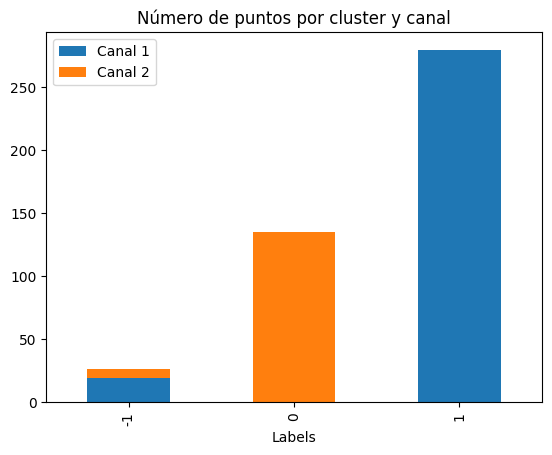

In [25]:
ax = pd.DataFrame(df_wholesome_customers[['Labels', 'Channel']].groupby('Labels').value_counts()).unstack().plot(kind='bar', stacked=True, title='Número de puntos por cluster y canal')
ax.legend(['Canal 1', 'Canal 2']);

*El cluster 1 representa el canal 1 (Horeca), el cluster 0 representa el canal 2 (Retail)*

In [26]:
#El canal 1 (Horeca) gasta mas en Fresh de media
pd.set_option('display.max_rows', 500)
pd.DataFrame(df_wholesome_customers.groupby(['Labels', 'Channel']).mean().transpose().loc['Fresh'])

Fresh
Labels Channel              
-1     1        15391.789474
       2         3851.000000
 0     2         9166.348148
 1     1        13345.064516

In [27]:
#El canal 2 (Retail) gasta mas en Grocery de media
pd.set_option('display.max_rows', 500)
pd.DataFrame(df_wholesome_customers.groupby(['Labels', 'Channel']).mean().transpose().loc['Grocery'])

Grocery
Labels Channel              
-1     1         7240.052632
       2        27207.142857
 0     2        15758.481481
 1     1         3738.910394

*CONCLUSION: En este caso, ya tenemos la variable canal y por tanto nuestro clustering se queda corto, podríamos separar los dos canales y hacer un clustering por canal para obtener mejores selecciones. A titulo educativo, sí es interesante considerar que si no tuvieramos ese dato (raro pero podría ser) entonces la agrupación de DBSCAN hubiera tenido todo el sentido (la utilidad es otra cosa). Te invito a que hagas un kmeans ahora con k = 2 y compruebes la clusterización de este*